### Exploring gluonts
https://ts.gluon.ai/stable/?utm_source=pocket_mylist

see also
https://github.com/microprediction


In [50]:
## setup
import os
import sys
import importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
#import pickle
from datetime import timedelta
import json

import plotly.express as px
import matplotlib.pyplot as plt


## variables
#dataDir = '../data/'



In [7]:
#reload_flag=1
#if reload_flag:
#    importlib.reload(eda)

In [54]:
#installation of gluonts
!{sys.executable} -m pip install 'gluonts[mxnet,pro,Prophet]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 7.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.3/986.3 kB 8.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00:00:0100:01


## Quick Example

To illustrate how to use GluonTS, we train a DeepAR-model and make predictions using the simple “airpassengers” dataset. The dataset consists of a single time-series, containing monthly international passengers between the years 1949 and 1960, a total of 144 values (12 years * 12 months). We split the dataset into train and test parts, by removing the last three years (36 month) from the train data. Thus, we will train a model on just the first nine years of data.

In [21]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes

#from gluonts.model import DeepAREtimator
from gluonts.mx import Trainer

from gluonts.model.deepar import DeepAREstimator

In [14]:
dataset = get_dataset("airpassengers")
deepar = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = deepar.train(dataset.train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.71it/s, epoch=5/5, avg_epoch_loss=4]


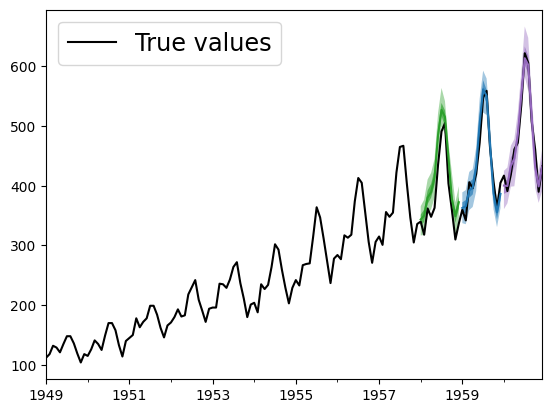

In [20]:
# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")
plt.legend(["True values"], loc="upper left", fontsize="xx-large")

## quick look at data sets


In [22]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


In [23]:
dataset = get_dataset("m4_hourly")

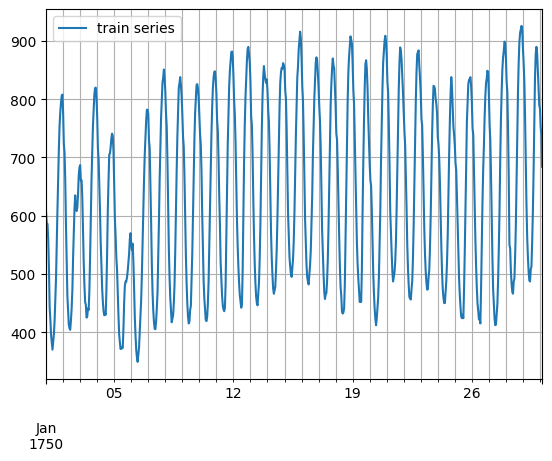

In [24]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

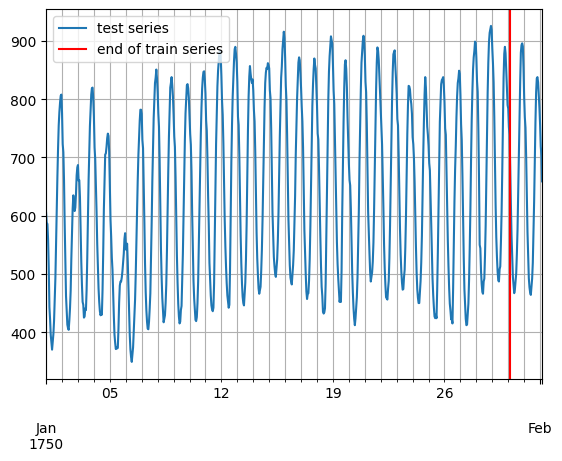

In [25]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [26]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Custom datasets

In [27]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

In [31]:

from gluonts.dataset.common import ListDataset
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

## Training an existing model (Estimator)
(also try and do Prophet)


In [126]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.tft import TemporalFusionTransformerEstimator
from gluonts.model.prophet import ProphetPredictor
from gluonts.mx import Trainer

In [68]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)
predictor = estimator.train(dataset.train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.04it/s, epoch=5/5, avg_epoch_loss=4.69]


In [101]:
estimator_deep = DeepAREstimator(
#    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    freq="H",
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)
predictor_deep = estimator_deep.train(dataset.train)
#deepar = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
#model = deepar.train(dataset.train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s, epoch=5/5, avg_epoch_loss=4.33]


In [127]:
estimator_tft = TemporalFusionTransformerEstimator(
#    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    freq="H",
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)
predictor_tft = estimator_tft.train(dataset.train)
#deepar = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
#model = deepar.train(dataset.train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s, epoch=5/5, avg_epoch_loss=117]


In [ ]:

proph_freq = dataset.metadata.freq
proph_length = dataset.metadata.prediction_length
predictor_proph = ProphetPredictor(proph_length)
predictions_proph = list(predictor_proph.predict(dataset.train))

In [74]:
predictions_proph[0].samples
predictions_proph[0].quantile(0.5)

array([667.12611681, 612.45348252, 556.4409302 , 522.60624119,
       502.11518417, 499.40931362, 496.20848553, 500.12501087,
       502.33326245, 549.18067621, 612.18798568, 676.5350111 ,
       737.5310373 , 783.1109107 , 841.36889358, 854.84093293,
       867.19588922, 877.42641173, 872.13539085, 848.11623585,
       822.77728962, 786.59613854, 748.00079353, 713.79021259,
       653.8641336 , 590.85630837, 542.73579214, 513.94249917,
       490.9625744 , 478.78455935, 476.44862422, 475.99101961,
       494.2147744 , 545.58967497, 594.77409352, 653.6403468 ,
       733.00587848, 785.50383013, 822.12892289, 855.21924668,
       874.02796293, 869.45062532, 864.90024614, 853.89490199,
       831.8901016 , 802.66138258, 760.54384604, 736.19302231])

## Visualise and evaluate

GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

Removes the final window of length prediction_length of the dataset.test that we want to predict

The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed

The module outputs the forecast sample paths and the dataset.test (as python generator objects)

In [75]:
from gluonts.evaluation import make_evaluation_predictions

In [115]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [102]:
forecast_it_deep, ts_it_deep = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor_deep,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [128]:
forecast_it_tft, ts_it_tft = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor_tft,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [77]:
forecast_it_proph, ts_it_proph = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor_proph,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [116]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [104]:
forecasts_deep = list(forecast_it_deep)
tss_deep = list(ts_it_deep)

In [129]:
forecasts_tft = list(forecast_it_tft)
tss_tft = list(ts_it_tft)

In [ ]:
forecasts_proph = list(forecast_it_proph)
tss_proph = list(ts_it_proph)

In [79]:
# first entry of the time series list
ts_entry = tss[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)


array([605., 586., 586., 559., 511.], dtype=float32)

In [106]:
# first entry of the time series list
ts_entry_deep = tss_deep[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry_deep[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [130]:
# first entry of the time series list
ts_entry_tft = tss_tft[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry_tft[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [80]:
# first entry of the time series list
ts_entry_proph = tss_proph[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry_proph[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [81]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))
# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [82]:
# first entry of the forecast list
forecast_entry = forecasts[0]
print("SimpleFeedForwardEstimator")
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

SimpleFeedForwardEstimator
Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [107]:
# first entry of the forecast list
forecast_entry_deep = forecasts_deep[0]
print("DeepAR")
print(f"Number of sample paths: {forecast_entry_deep.num_samples}")
print(f"Dimension of samples: {forecast_entry_deep.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry_deep.start_date}")
print(f"Frequency of the time series: {forecast_entry_deep.freq}")

DeepAR
Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [151]:
# first entry of the forecast list
forecast_entry_tft = forecasts_tft[0]
print("TFT")
#print(f"Number of sample paths: {forecast_entry_tft.num_samples}")
#print(f"Dimension of samples: {forecast_entry_tft.samples.shape}")
print(f"Prediction length: {forecast_entry_tft.prediction_length}")
print(f"Start date of the forecast window: {forecast_entry_tft.start_date}")
print(f"Frequency of the time series: {forecast_entry_tft.freq}")

TFT
Prediction lenght: 48
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [83]:
# first entry of the forecast list
forecast_entry_proph = forecasts_proph[0]
print("Prophet")
print(f"Number of sample paths: {forecast_entry_proph.num_samples}")
print(f"Dimension of samples: {forecast_entry_proph.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry_proph.start_date}")
print(f"Frequency of the time series: {forecast_entry_proph.freq}")

Prophet
Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [84]:
print("SimpleFeedForwardEstimator")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

SimpleFeedForwardEstimator
Mean of the future window:
 [651.2594  547.1128  610.1792  470.9054  443.98303 465.49    565.32733
 496.1904  499.3277  494.98428 710.4995  659.7617  828.1995  805.1892
 966.282   903.72437 802.313   971.3206  862.6887  806.567   748.11255
 816.67267 732.52435 821.4462  526.8494  618.2865  567.8568  449.15875
 511.90387 388.68466 455.06976 456.13266 494.96594 617.2552  602.84937
 736.08875 744.5781  682.025   849.76013 826.55505 835.0014  753.3959
 657.19977 833.0414  841.05005 718.864   705.7195  671.36615]
0.5-quantile (median) of the future window:
 [643.9147  534.4863  613.8885  483.02625 448.34528 466.25052 557.6208
 504.38318 477.80508 489.43698 701.69446 659.6001  811.09985 817.0422
 967.2289  907.49896 804.3095  947.90796 875.07135 811.9364  778.9244
 805.10767 755.5802  809.1451  558.5245  633.3991  561.0988  482.5019
 523.5272  389.63852 451.66235 445.07434 501.76654 615.26154 608.56946
 724.47253 759.4809  694.2437  849.46826 833.0294  856.2714  76

In [108]:
print("DeepAR")
print(f"Mean of the future window:\n {forecast_entry_deep.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry_deep.quantile(0.5)}")

DeepAR
Mean of the future window:
 [617.735   573.4429  543.9835  502.0532  472.3371  497.32236 457.56433
 486.3728  509.80408 560.40967 609.0546  697.5229  734.76953 765.73444
 806.04614 840.8484  849.0511  801.4231  812.16284 765.8709  735.3011
 694.9818  656.8733  626.3962  572.1028  511.3449  487.4441  472.95578
 434.37762 437.87524 435.1784  441.72226 463.6443  510.3743  573.8257
 649.51666 699.0528  745.34845 759.90045 770.57477 763.8407  732.3897
 692.50244 674.2087  704.82275 673.0643  661.2061  608.07697]
0.5-quantile (median) of the future window:
 [618.7409  573.3694  536.5563  499.2887  475.39896 467.60126 483.671
 487.2636  514.4185  567.4574  619.1592  687.29095 743.94214 757.46
 803.46234 864.673   858.25397 796.6623  810.2398  752.4936  741.6653
 694.8084  651.38586 619.3586  569.04456 510.6315  483.5176  455.44672
 444.0207  435.88876 437.14755 447.9394  464.7034  508.54166 570.8428
 650.5464  686.1801  730.11017 758.03577 760.5377  765.5944  733.99243
 729.07495 675.1

In [154]:
print("TFT")
print(f"Mean of the future window:\n {forecast_entry_tft.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry_tft.quantile(0.5)}")

TFT
Mean of the future window:
 [603.469   545.99695 505.29596 483.11627 467.17072 456.6777  457.16602
 465.9859  485.08743 516.2894  557.3535  607.47064 660.5781  709.6313
 750.2241  780.8352  801.53156 814.2146  821.9424  826.94916 814.5947
 797.4002  749.882   685.5142  621.2811  558.48645 512.76526 484.17725
 464.19965 451.985   451.98743 460.89148 480.33838 510.9494  550.87134
 601.4354  656.6351  707.18115 748.1184  778.8481  799.6584  812.39215
 820.14795 825.181   801.94116 783.08746 733.0184  666.896  ]
0.5-quantile (median) of the future window:
 [603.469   545.99695 505.29596 483.11627 467.17072 456.6777  457.16602
 465.9859  485.08743 516.2894  557.3535  607.47064 660.5781  709.6313
 750.2241  780.8352  801.53156 814.2146  821.9424  826.94916 814.5947
 797.4002  749.882   685.5142  621.2811  558.48645 512.76526 484.17725
 464.19965 451.985   451.98743 460.89148 480.33838 510.9494  550.87134
 601.4354  656.6351  707.18115 748.1184  778.8481  799.6584  812.39215
 820.14795 82

In [85]:
print("Prophet")
print(f"Mean of the future window:\n {forecast_entry_proph.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry_proph.quantile(0.5)}")

Prophet
Mean of the future window:
 [674.1925728  611.0574816  560.62937215 519.75469432 500.24003084
 496.96236484 490.85829662 498.60462967 512.0711125  553.36121062
 601.64762805 664.76219493 740.29031054 789.96986748 832.50174404
 844.53475321 873.85940589 871.18824916 864.62708328 847.11860867
 819.0735808  792.744711   752.57152832 706.22231576 654.97906858
 596.01901931 540.72192012 507.510762   491.31997244 481.68486885
 478.95773396 485.64183945 494.26854182 527.86013424 590.4256613
 666.0249325  736.69598899 788.34367793 827.61054852 851.62785027
 866.86316907 868.84381134 870.26566322 854.43893377 831.23724352
 801.57774915 772.75569866 723.29512167]
0.5-quantile (median) of the future window:
 [674.95205099 613.74445846 562.89950114 517.08403089 505.28865443
 495.0376916  490.97268486 494.18927957 514.00392936 548.93770647
 600.3208139  664.90450553 736.6036603  795.13286821 836.5128109
 845.80883929 879.5764292  874.73170418 864.9214177  846.59608214
 822.96547064 792.6115

In [86]:
def plot_prob_forecasts(ts_entry, forecast_entry, title):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.title(title)
    plt.legend(legend, loc="upper left")
    plt.show()

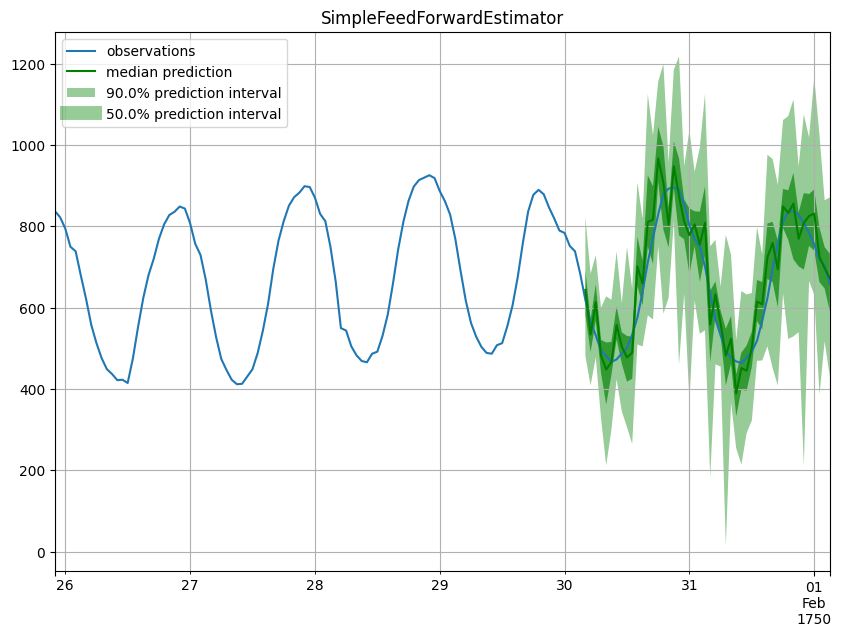

In [87]:
plot_prob_forecasts(ts_entry, forecast_entry, "SimpleFeedForwardEstimator")

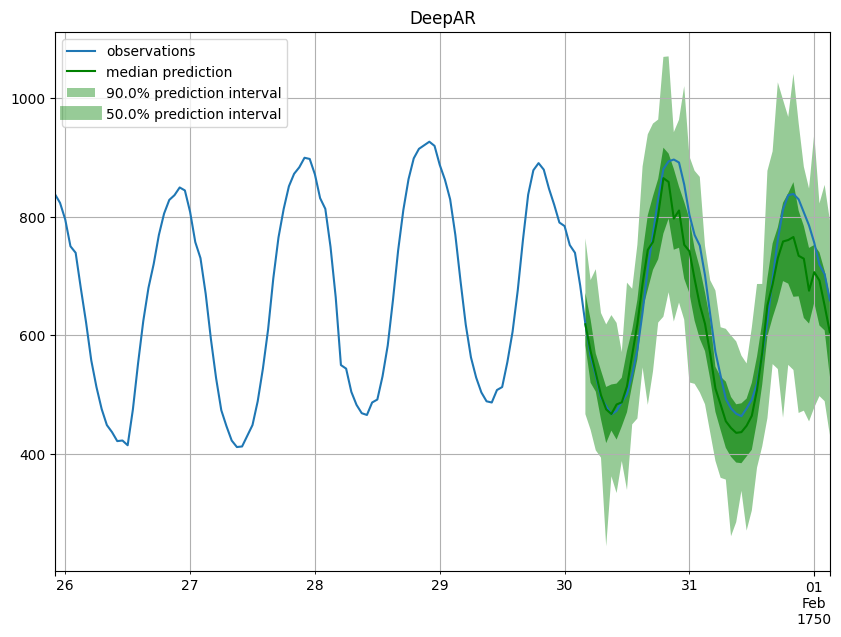

In [109]:
plot_prob_forecasts(ts_entry_deep, forecast_entry_deep, "DeepAR")

AttributeError: 'Line2D' object has no property 'prediction_intervals'

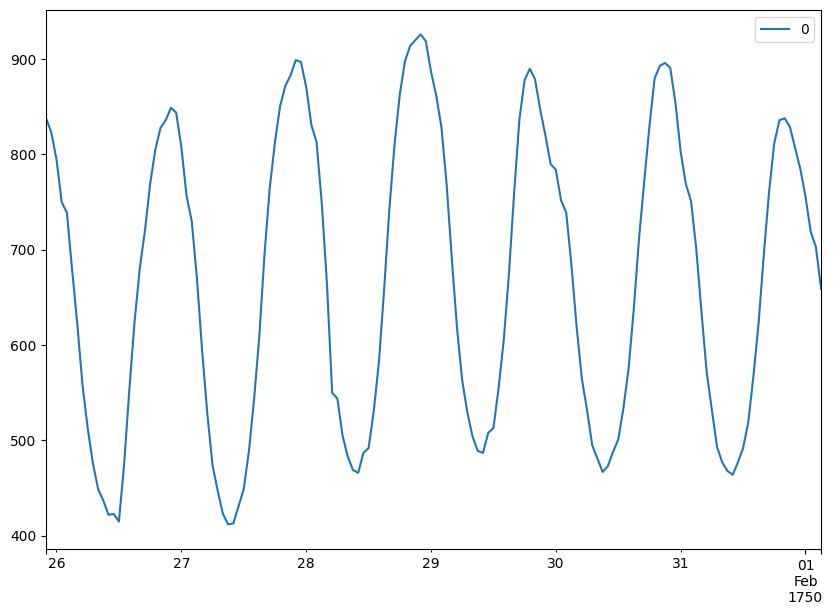

In [155]:
plot_prob_forecasts(ts_entry_tft, forecast_entry_tft, "TFT")

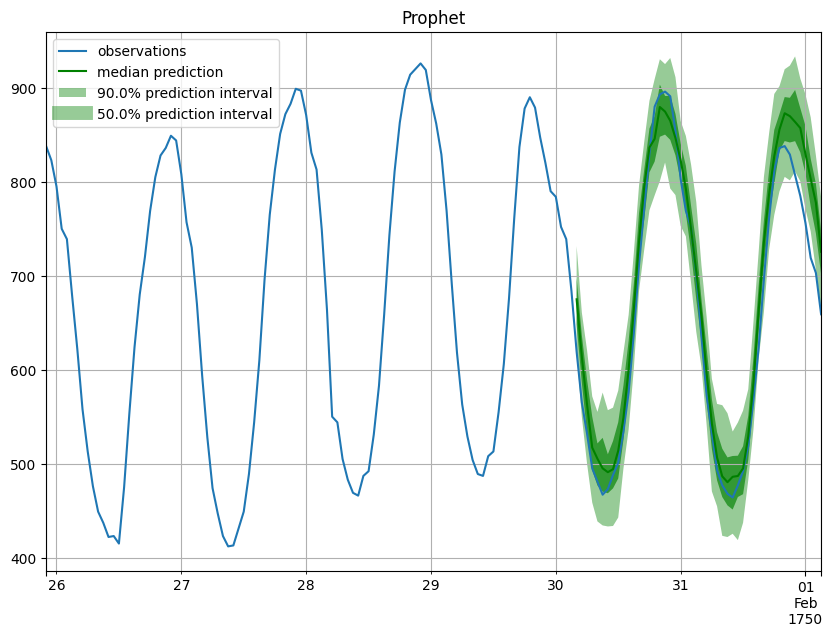

In [88]:
plot_prob_forecasts(ts_entry_proph, forecast_entry_proph, "Prophet")

In [47]:
from gluonts.evaluation import Evaluator


In [117]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])


Running evaluation: 414it [00:00, 4059.74it/s]
Running evaluation: 414it [00:00, 4195.30it/s]
Running evaluation: 414it [00:00, 4240.11it/s]


In [90]:
agg_metrics, item_metrics = evaluator(tss, forecasts)
print("SimpleFeedForwardEstimator")
print(json.dumps(agg_metrics, indent=4))

SimpleFeedForwardEstimator
{
    "MSE": 12685144.85381818,
    "abs_error": 10731264.464477539,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 5.465548202936764,
    "MAPE": 0.2716789721314842,
    "sMAPE": 0.21166625809698286,
    "MSIS": 75.35933804553845,
    "QuantileLoss[0.1]": 6401935.275947667,
    "Coverage[0.1]": 0.11015499194847023,
    "QuantileLoss[0.5]": 10731264.48413229,
    "Coverage[0.5]": 0.4690016103059581,
    "QuantileLoss[0.9]": 7619228.703639982,
    "Coverage[0.9]": 0.8780696457326892,
    "RMSE": 3561.6210991370463,
    "NRMSE": 0.4862399494732062,
    "ND": 0.07372456887267384,
    "wQuantileLoss[0.1]": 0.043981761863417346,
    "wQuantileLoss[0.5]": 0.07372456900770341,
    "wQuantileLoss[0.9]": 0.05234465641747721,
    "mean_absolute_QuantileLoss": 8250809.487906647,
    "mean_wQuantileLoss": 0.056683662429532655,
    "MAE_Coverage": 0.02102791196994098,
    "OWA": NaN


In [118]:
agg_metrics_deep, item_metrics_deep = evaluator(tss_deep, forecasts_deep)
print("DeepAR")
print(json.dumps(agg_metrics_deep, indent=4))

DeepAR
{
    "MSE": 57527708.06712528,
    "abs_error": 20700293.780895233,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.9952375219168483,
    "MAPE": 0.16421415377258294,
    "sMAPE": 0.16499275647571698,
    "MSIS": 49.975568004874475,
    "QuantileLoss[0.1]": 9918934.891500283,
    "Coverage[0.1]": 0.04186795491143318,
    "QuantileLoss[0.5]": 20700293.789117336,
    "Coverage[0.5]": 0.21769323671497584,
    "QuantileLoss[0.9]": 5563562.173917579,
    "Coverage[0.9]": 0.7990136876006441,
    "RMSE": 7584.702239846023,
    "NRMSE": 1.035479387396266,
    "ND": 0.1422125267330734,
    "wQuantileLoss[0.1]": 0.06814380551076865,
    "wQuantileLoss[0.5]": 0.14221252678955984,
    "wQuantileLoss[0.9]": 0.03822207755909211,
    "mean_absolute_QuantileLoss": 12060930.284845067,
    "mean_wQuantileLoss": 0.0828594699531402,
    "MAE_Coverage": 0.14714170692431564,
    "OWA": NaN
}


In [157]:
agg_metrics_tft, item_metrics_tft = evaluator(tss_tft, forecasts_tft)
print("TFT")
print(json.dumps(agg_metrics_tft, indent=4))

Running evaluation: 414it [00:00, 1605.85it/s]


TFT
{
    "MSE": 5852324.080783604,
    "abs_error": 10739645.113315582,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 14.387255293267847,
    "MAPE": 1.04791630267641,
    "sMAPE": 0.46650789317865404,
    "MSIS": 52.93571662397066,
    "QuantileLoss[0.1]": 5552889.3481964115,
    "Coverage[0.1]": 0.25407608695652173,
    "QuantileLoss[0.5]": 10739645.118009567,
    "Coverage[0.5]": 0.41490539452495967,
    "QuantileLoss[0.9]": 6014258.720823478,
    "Coverage[0.9]": 0.6883051529790661,
    "RMSE": 2419.1577213533646,
    "NRMSE": 0.3302684635610405,
    "ND": 0.07378214454090039,
    "wQuantileLoss[0.1]": 0.038148754468644484,
    "wQuantileLoss[0.5]": 0.0737821445731484,
    "wQuantileLoss[0.9]": 0.041318395679200794,
    "mean_absolute_QuantileLoss": 7435597.729009819,
    "mean_wQuantileLoss": 0.05108309824033122,
    "MAE_Coverage": 0.150288513150832,
    "OWA": NaN
}


In [119]:
agg_metrics_proph, item_metrics_proph = evaluator(tss_proph, forecasts_proph)
print("Proph")
print(json.dumps(agg_metrics_proph, indent=4))

Proph
{
    "MSE": 3019862.4216366624,
    "abs_error": 7658126.282061282,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 1.6396485112976462,
    "MAPE": 0.2906364439106788,
    "sMAPE": 0.18198198131595658,
    "MSIS": 14.644696509130322,
    "QuantileLoss[0.1]": 4500254.864793624,
    "Coverage[0.1]": 0.1667169887278583,
    "QuantileLoss[0.5]": 7658126.282061282,
    "Coverage[0.5]": 0.4970813204508857,
    "QuantileLoss[0.9]": 3530082.579109905,
    "Coverage[0.9]": 0.8076187600644121,
    "RMSE": 1737.7751355214698,
    "NRMSE": 0.23724469014867547,
    "ND": 0.05261188561575053,
    "wQuantileLoss[0.1]": 0.030917078860773002,
    "wQuantileLoss[0.5]": 0.05261188561575053,
    "wQuantileLoss[0.9]": 0.02425192456036307,
    "mean_absolute_QuantileLoss": 5229487.908654937,
    "mean_wQuantileLoss": 0.03592696301229553,
    "MAE_Coverage": 0.05400563607085349,
    "OWA": NaN
}


In [120]:
print("SimpleFeedForwardEstimator")
item_metrics.head()

SimpleFeedForwardEstimator


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,3367.375326,2241.412598,31644.0,659.250000,42.371302,1.102069,0.074595,0.072434,0.070832,15.529398,1332.364459,0.041667,2241.412567,0.604167,1513.464960,1.000000
1,1,217109.645833,17536.939453,124149.0,2586.437500,165.107988,2.212812,0.150818,0.135338,0.141257,17.454921,7345.800488,0.270833,17536.940552,0.958333,9370.601465,1.000000
2,2,56475.723958,8780.357422,65030.0,1354.791667,78.889053,2.318752,0.124276,0.133891,0.135020,15.901894,3869.348889,0.000000,8780.357605,0.270833,4480.851562,0.770833
3,3,343760.500000,20895.607422,235783.0,4912.145833,258.982249,1.680907,0.087203,0.088894,0.088622,17.407280,11440.003809,0.041667,20895.607178,0.437500,8902.399902,0.937500
4,4,69267.770833,10813.412109,131088.0,2731.000000,200.494083,1.123621,0.087728,0.085101,0.082490,15.802397,6175.671753,0.020833,10813.412354,0.645833,7291.772803,1.000000


In [121]:
print("DeepAR")
item_metrics_deep.head()

DeepAR


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,2744.269857,2004.887085,31644.0,659.250000,42.371302,0.985773,0.059807,0.062039,0.063358,11.316679,1474.775757,0.0,2004.887085,0.250000,825.590259,1.000000
1,1,31987.739583,7647.320801,124149.0,2586.437500,165.107988,0.964939,0.063985,0.062087,0.061598,13.382262,4489.012988,0.0,7647.320801,0.729167,6087.748437,1.000000
2,2,123822.989583,13846.927734,65030.0,1354.791667,78.889053,3.656751,0.194717,0.223240,0.212931,21.798383,4837.922485,0.0,13846.928284,0.000000,10570.525281,0.395833
3,3,560514.250000,27858.742188,235783.0,4912.145833,258.982249,2.241043,0.111699,0.122472,0.118154,13.650284,14244.781250,0.0,27858.741455,0.145833,8614.281396,0.666667
4,4,320038.625000,23189.523438,131088.0,2731.000000,200.494083,2.409623,0.169457,0.189065,0.176900,10.356904,9233.484387,0.0,23189.523682,0.000000,10882.359180,0.541667


In [158]:
print("TFT")
item_metrics_tft.head()

TFT


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1542.132812,1479.683350,31644.0,659.250000,42.371302,0.727538,0.043466,0.044429,0.046760,10.068229,1269.088245,0.000000,1479.683289,0.166667,931.138147,1.000000
1,1,69939.875000,11644.388672,124149.0,2586.437500,165.107988,1.469289,0.104938,0.098153,0.093794,10.784932,3344.760645,0.145833,11644.388916,0.979167,7010.478516,1.000000
2,2,103192.812500,12828.170898,65030.0,1354.791667,78.889053,3.387714,0.178687,0.202644,0.197265,62.016276,3840.050830,0.000000,12828.170471,0.000000,14284.324146,0.395833
3,3,288171.812500,20214.660156,235783.0,4912.145833,258.982249,1.626130,0.083387,0.087812,0.085734,15.255555,8438.441357,0.000000,20214.659668,0.375000,14939.608301,0.770833
4,4,465370.625000,26264.046875,131088.0,2731.000000,200.494083,2.729096,0.194647,0.219945,0.200354,31.745690,8848.665796,0.000000,26264.046021,0.312500,21050.771484,0.625000


In [122]:
print("Prophet")
item_metrics_proph.head()

Prophet


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,1145.926924,1314.691650,31644.0,659.250000,42.371302,0.646414,0.041512,0.040364,0.041546,3.847078,552.160222,0.166667,1314.691650,0.875000,668.724932,1.000000
1,None,242546.588469,22848.291177,124149.0,2586.437500,165.107988,2.882998,0.198643,0.177845,0.184039,40.444561,23135.479313,1.000000,22848.291177,1.000000,6503.696058,1.000000
2,None,64775.847836,10826.700668,65030.0,1354.791667,78.889053,2.859158,0.158597,0.174063,0.166488,50.989966,3109.769187,0.000000,10826.700668,0.000000,11584.366325,0.083333
3,None,150233.741855,15571.172326,235783.0,4912.145833,258.982249,1.252593,0.064009,0.065282,0.066040,13.849486,7228.552981,0.104167,15571.172326,0.229167,9318.387435,0.458333
4,None,70584.665441,11683.653476,131088.0,2731.000000,200.494083,1.214048,0.093989,0.090646,0.089128,5.252177,3630.249964,0.270833,11683.653476,0.687500,4829.035553,0.854167


SimpleFeedForwardEstimator


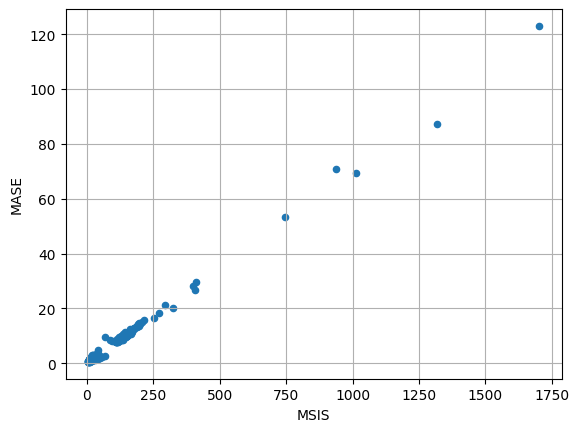

In [123]:
print("SimpleFeedForwardEstimator")
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

DeepAR


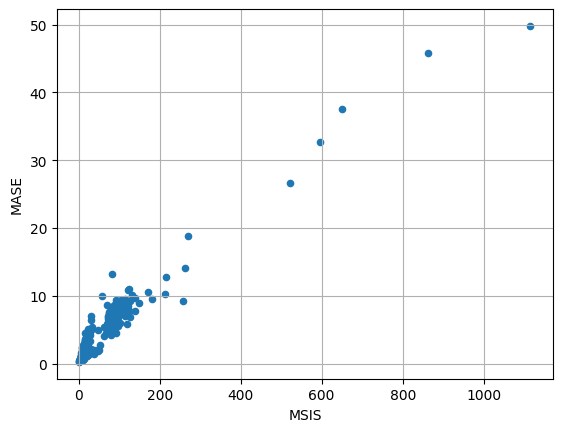

In [124]:
print("DeepAR")
item_metrics_deep.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

TFT


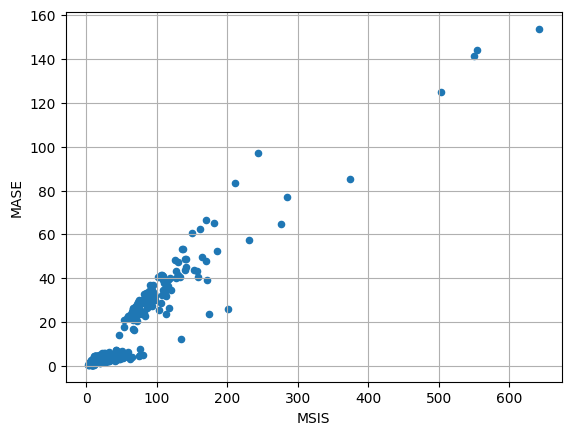

In [159]:
print("TFT")
item_metrics_tft.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

Proph


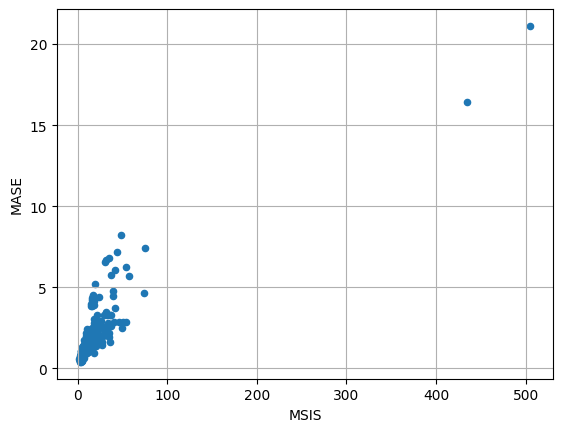

In [125]:
print("Proph")
item_metrics_proph.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()